# Nonlinear Neural Networks

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

2    40365
1    40188
0    40139
4    39880
3    39428
Name: kmeans_label, dtype: int64


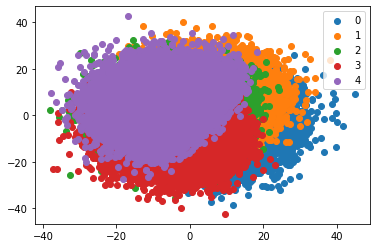

In [ ]:
# Load
import pandas as pd
df = pd.read_csv('student_simulation.csv')

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Pre-label data with Kmeans
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df[['gender','race','international_stu','technical_skill']] = enc.fit_transform(df[['gender','race','international_stu','technical_skill']])
df[['gender','race','international_stu','technical_skill']] = df[['gender','race','international_stu','technical_skill']].astype(int)
from sklearn.cluster import KMeans
df_sample = df[:200000]
kmeans = KMeans(5)
identified_clusters = kmeans.fit_predict(df_sample)
for i in range(len(identified_clusters)):
  df_sample.at[i,'kmeans_label']=identified_clusters[i]
df_sample[['kmeans_label']] = df_sample[['kmeans_label']].astype(int)
# Distribution of labels
print(df_sample['kmeans_label'].value_counts())
# Plot
label = np.array(df_sample.kmeans_label)
u_labels_df_sample = np.unique(df_sample.kmeans_label)
pca_df_sample = df_sample.drop(columns='kmeans_label')
pca_sample = PCA(2)
pca_df_sample = pca_sample.fit_transform(pca_df_sample)
for i in u_labels_df_sample:
    plt.scatter(pca_df_sample[label==i,0],pca_df_sample[label==i,1],label=i)
plt.legend()
plt.show()


In [ ]:
# Packages
import torch
import torch.nn as nn

# Class dataset
from torch.utils.data import Dataset, DataLoader, random_split
class SIMULATE_dataset(Dataset):
    def __init__(self, featuers, labels):
        self.length = len(labels)
        self.features = torch.Tensor(featuers)
        self.labels = torch.LongTensor(labels)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    
    def __len__(self):
        return self.length   

# Convert dataset
train_x = df_sample.iloc[:100000,:16].values
test_x = df_sample.iloc[100000:,:16].values
train_y = df_sample.iloc[:100000,16].values
test_y = df_sample.iloc[100000:,16].values

train_dataset = SIMULATE_dataset(train_x, train_y)
test_dataset = SIMULATE_dataset(test_x, test_y)


In [ ]:
# NN models
class linear_model(nn.Module):
    def __init__(self, hidden_units1, hidden_units2=None):
        super(linear_model, self).__init__()
        if hidden_units2 == None:
            self.classifier = nn.Sequential(
                nn.Linear(in_features=16, out_features=hidden_units1),
                nn.ReLU(),
                nn.Linear(in_features=hidden_units1, out_features=5)
            )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(in_features=16, out_features=hidden_units1),
                nn.ReLU(),
                nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
                nn.ReLU(),
                nn.Linear(in_features=hidden_units2, out_features=5)
          )

    def forward(self, x):
        output = x
        output = self.classifier(x)
        #torch.nn.functional.relu(x)
        
        return output


In [ ]:
# Define a function to train the model 
def train_model(model, train_dataset, test_dataset, device,\
                lr=0.0005, epochs=20, batch_size=32):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # setup loss function and optimizer
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    # early stopping
    min_eval_loss = 10000
    epochs_no_improvement = 0
    
    # define training function
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0

        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x)
            _, pred_class = torch.max(outputs, dim=1)
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred_class == y).sum().item() / batch_size
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc
      
        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x)
                _, pred_class = torch.max(outputs, dim=1)
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred_class == y).sum().item() / batch_size 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.5f} train_acc:{train_acc:.5f}, valid loss:{val_loss:.5f} valid acc:{val_acc:.5f}")

        # early stopping
        if val_loss < min_eval_loss:
            torch.save(model.state_dict(), 'model.pth')
            print('model saved!')
            epochs_no_improvement = 0
            min_eval_loss = val_loss
        else:
            epochs_no_improvement += 1
      
        if epoch == 50:
            print('early stopping!')
            break
        

    return history


In [ ]:
# Train
model = linear_model(32)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=test_dataset,
                      device=device,
                      lr=0.0005,
                      epochs=100,
                      batch_size=32)


Training Start
Epoch:1 / 100, train loss:0.72995 train_acc:0.73536, valid loss:0.49196 valid acc:0.80738
model saved!
Epoch:2 / 100, train loss:0.47278 train_acc:0.80935, valid loss:0.43718 valid acc:0.82702
model saved!
Epoch:3 / 100, train loss:0.45443 train_acc:0.81440, valid loss:0.46822 valid acc:0.80489
Epoch:4 / 100, train loss:0.44832 train_acc:0.81649, valid loss:0.48217 valid acc:0.79839
Epoch:5 / 100, train loss:0.44419 train_acc:0.81834, valid loss:0.45425 valid acc:0.81089
Epoch:6 / 100, train loss:0.44226 train_acc:0.81915, valid loss:0.41598 valid acc:0.83299
model saved!
Epoch:7 / 100, train loss:0.43859 train_acc:0.82073, valid loss:0.42909 valid acc:0.82648
Epoch:8 / 100, train loss:0.43612 train_acc:0.82118, valid loss:0.42711 valid acc:0.82312
Epoch:9 / 100, train loss:0.43402 train_acc:0.82323, valid loss:0.41293 valid acc:0.83157
model saved!
Epoch:10 / 100, train loss:0.43137 train_acc:0.82319, valid loss:0.46237 valid acc:0.81226
Epoch:11 / 100, train loss:0.428

In [ ]:
# Predict the rest of df
predict = torch.Tensor(df.values)
predict = predict.to(device)

model.load_state_dict(torch.load('model.pth'))
outputs = model(predict)
_, pred_class = torch.max(outputs, dim=1)

for i in range(len(pred_class)):
  df.at[i,'label'] = pred_class[i].item()

df[['label']] = df[['label']].astype(int)


## Visualization & Summary

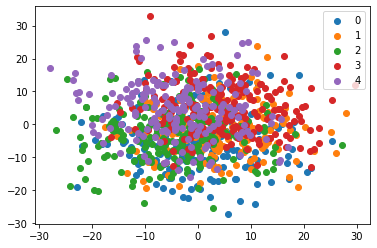

In [ ]:
# Plot 1000 samples
filter_data = df.sample(1000)
label = np.array(filter_data.label)
u_labels_filter = np.unique(filter_data.label)
pca_filter_data = filter_data.drop(columns='label')
pca_filter = PCA(2)
pca_filter_data = pca_filter.fit_transform(pca_filter_data)
for i in u_labels_filter:
    plt.scatter(pca_filter_data[label==i,0],pca_filter_data[label==i,1],label=i)
plt.legend()
plt.show()


In [ ]:
# download
df.to_csv('label_linearNN.csv', index=False)
from google.colab import files
files.download('label_linearNN.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
pivot_df = pd.read_csv('label_linearNN.csv')
import numpy as np


In [ ]:
table = pd.pivot_table(pivot_df, values=['gender','reading_score','Teamwork','Empathy_skills','Self-control','Ability_to_compromise',\
                    'Ability_to_teach','Respect_for_others','Openness_to_Criticism','Sensitivity_and_Tact',\
                             'Gaining_trust','Comfort_with_Differences','Listening_Skills'],\
                    index=['label'],
                    aggfunc=np.mean)
table


,Ability_to_compromise,Ability_to_teach,Comfort_with_Differences,Empathy_skills,Gaining_trust,Listening_Skills,Openness_to_Criticism,Respect_for_others,Self-control,Sensitivity_and_Tact,Teamwork,gender,reading_score
label,,,,,,,,,,,,,
0,74.600541,78.777953,83.211306,78.073402,79.945225,74.550831,84.465847,77.182999,78.853775,80.413215,86.328382,0.508193,3.205416
1,83.374420,74.764023,80.788818,76.118101,84.266473,81.335691,80.687882,77.447052,85.758983,83.720559,77.389168,0.491527,3.108422
2,82.934824,80.902152,76.824496,86.817034,74.842661,83.220170,80.029949,74.112732,78.685975,80.546008,80.532900,0.502426,3.179409
3,76.048280,80.360588,76.597009,80.235362,79.050365,81.936590,75.390597,88.218288,81.305680,80.614014,82.299034,0.494958,3.151137
4,83.347692,84.256506,83.081475,78.211061,82.477096,78.682840,80.077875,81.892261,76.136239,75.251871,73.514224,0.505029,3.198194
